In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

from google.cloud import bigquery
from google.oauth2 import service_account

In [17]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [18]:
sSheet=rf'ProyecciónValidarProy_Res'
sSheet=rf'ProyecciónValidarProy_ResF'
pathfile=rf"C:\Alejo\Eje de Planeación\Análisis Energético\Ejecuciones 30 días\ValidaciónErrores\{sSheet}.csv"
df_proyIni = pd.read_csv(pathfile, delimiter=',',header=0,encoding="ISO-8859-1")
df_proyIni=df_proyIni[['Fecha','TipoDia','TBS_Total-GBTU','TCCC-GBTU']]
df_proyIni=df_proyIni.rename(columns={'TBS_Total-GBTU':'TBSTp','TCCC-GBTU':'TCDTp'})
df_proyIni['Fecha'] = pd.to_datetime(df_proyIni['Fecha']).dt.date
df_proyIni=df_proyIni.fillna(0)
df_proyIni

,Fecha,TipoDia,TBSTp,TCDTp
0,2025-09-15,O,83.946683,48.325243
1,2025-09-16,O,62.294557,44.863513
2,2025-09-17,O,57.845053,39.419332
3,2025-09-18,O,42.292455,31.394883
4,2025-09-19,O,74.981914,46.331676
...,...,...,...,...
118,2026-01-11,F,0.000000,31.385294
119,2026-01-12,F,0.000000,29.250148
120,2026-01-13,O,0.000000,48.774453
121,2026-01-14,O,0.000000,42.921380


In [19]:
FechaIni=pd.to_datetime(df_proyIni['Fecha']).min()
FechaFin=pd.to_datetime(df_proyIni['Fecha']).max()

In [20]:
# Consulta a la maestra de recursos
query = rf"""
SELECT * FROM `enersinc-tbsg-bq`.tbsg.public_ddec 
where fechaoperacion>='{FechaIni.strftime('%Y-%m-%d')}' and fechaoperacion <='{FechaFin.strftime('%Y-%m-%d')}' and nombre in ('TEBSAB CC','TERMOCANDELARIA CC','BARRANQUILLA 3','BARRANQUILLA 4')
order by fechaoperacion ,nombre
"""

# Ejecutar la consulta
df_GenDIni = client.query(query).to_dataframe()

query = rf"""
SELECT * FROM `enersinc-tbsg-bq`.tbsg.public_dconfig
where fechaoperacion>='{FechaIni.strftime('%Y-%m-%d')}' and fechaoperacion <='{FechaFin.strftime('%Y-%m-%d')}' and recurso in ('TEBSAB CC','TERMOCANDELARIA CC')
order by fechaoperacion ,recurso 
"""

# Ejecutar la consulta
df_ConfDIni = client.query(query).to_dataframe()

In [21]:
df_GenD=df_GenDIni.copy()
df_ConfD=df_ConfDIni.copy()

for i in range(1,25):
    df_GenD = df_GenD.rename(columns={f'hora{i}': i})
    if i<10:
        df_ConfD = df_ConfD.rename(columns={f'p0{i}': i})
    else:
        df_ConfD = df_ConfD.rename(columns={f'p{i}': i}) 


df_GenD = df_GenD.melt(id_vars=['fechaoperacion', 'nombre', 'version'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='gen')

df_ConfD = df_ConfD.melt(id_vars=['fechaoperacion', 'recurso', 'version'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='conf')

df_GenD['nombre'] = df_GenD['nombre'].replace({'BARRANQUILLA 3': 'TEBSAB CC', 'BARRANQUILLA 4': 'TEBSAB CC'})
df_GenD=df_GenD.groupby(['fechaoperacion','nombre','periodo'])[['gen']].sum().reset_index().round(2)

df_GenD=df_GenD.merge(df_ConfD,left_on=['fechaoperacion','nombre','periodo'],right_on=['fechaoperacion','recurso','periodo'], 
                        how='inner')[['fechaoperacion','recurso','periodo','gen','conf']]

df_GenD = df_GenD.pivot(index=['fechaoperacion','periodo'], columns='recurso', values=['gen','conf']).reset_index()

df_GenD.to_csv('DataGenDespacho.csv')
df_GenD

fechaoperacion periodo       gen                         conf  \
recurso                        TEBSAB CC TERMOCANDELARIA CC TEBSAB CC   
0           2025-09-15       1    305.47              260.0         2   
1           2025-09-15       2    275.52              209.0         2   
2           2025-09-15       3     246.6              125.0         2   
3           2025-09-15       4     210.0              125.0         2   
4           2025-09-15       5     246.0                0.0         2   
...                ...     ...       ...                ...       ...   
1219        2025-11-04      20    385.73              260.0         6   
1220        2025-11-04      21    449.74              260.0         9   
1221        2025-11-04      22    306.45              260.0         4   
1222        2025-11-04      23    295.18              260.0         2   
1223        2025-11-04      24     243.0             246.14         2   

                            
recurso TERMOCANDELARIA CC  
0                        3  
1                        3  
2                        1  
3                        1  
4                        0  
...                    ...  
1219                     3  
1220                     3  
1221                     3  
1222                     3  
1223                     3  

[1224 rows x 6 columns]

In [22]:
FechaIni=dt.date(FechaIni.year, FechaIni.month, FechaIni.day)
FechaFin=dt.date(FechaFin.year, FechaFin.month, FechaFin.day)

In [23]:
# Consutlar combustible
df_Comb= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ConsCombustibleMBTU",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_Comb.rename(columns={'Values_code':'planta'},inplace=True)
df_Comb=df_Comb.fillna(0)

In [24]:
df_CombIni=df_Comb.copy()
df_CombIni=df_CombIni[(df_CombIni['planta'].isin(['TBST','TBQ3','TBQ4','TCD2','TCD1','TCDT']))]

df_CombIni['TotalDia']=0
l_per=[]
for i in range(1,25):
    if i<10:
        l_per.append('Values_Hour0' + str(i))
    else:
        l_per.append('Values_Hour' + str(i))


for col in l_per:
    df_CombIni['TotalDia']=df_CombIni['TotalDia']+df_CombIni[col]

df_CombIni=df_CombIni[['Date','planta','TotalDia']]
df_CombIni['TotalDia']=round(df_CombIni['TotalDia']/1000,2)

df_CombIni['planta'] = df_CombIni['planta'].replace({'TBQ3': 'TBST', 'TBQ4': 'TBST'})
df_CombIni['planta'] = df_CombIni['planta'].replace({'TCD2': 'TCDT', 'TCD1': 'TCDT'})

df_CombIni=df_CombIni.groupby(['Date','planta'])[['TotalDia']].sum().reset_index().round(2)

df_CombIni['Date'] = df_CombIni['Date'].dt.date

df_CombIni = df_CombIni.pivot(index='Date', columns='planta', values='TotalDia').reset_index()

In [10]:
df_CombIni

planta,Date,TBST,TCDT
0,2025-09-15,76.51,57.01
1,2025-09-16,63.32,55.46
2,2025-09-17,65.63,43.13
3,2025-09-18,71.45,46.11
4,2025-09-19,72.72,56.04
5,2025-09-20,57.34,40.88
6,2025-09-21,54.13,56.46
7,2025-09-22,69.64,46.50
8,2025-09-23,79.44,64.10
9,2025-09-24,92.22,49.43


In [25]:
df_proy=df_proyIni.copy()
df_proy=df_proy.merge(df_CombIni,left_on=['Fecha'],right_on=['Date'], how='inner')[['Fecha','TipoDia','TBSTp','TCDTp','TBST','TCDT']]
df_proy['TB_Dif_GBTU']=df_proy['TBST']-df_proy['TBSTp']
df_proy['TC_Dif_GBTU']=df_proy['TCDT']-df_proy['TCDTp']
df_proy['TB_%']=100*(df_proy['TB_Dif_GBTU']/df_proy['TBSTp'])
df_proy['TC_%']=100*(df_proy['TC_Dif_GBTU']/df_proy['TCDTp'])
# Eliminar filas entre 2025-10-10 y 2025-10-14 (inclusive)
start = pd.to_datetime('2025-10-10').date()
end = pd.to_datetime('2025-10-17').date()
df_proy['Fecha'] = pd.to_datetime(df_proy['Fecha']).dt.date
df_proy = df_proy.loc[~df_proy['Fecha'].between(start, end)].reset_index(drop=True)
df_proy
df_proy.to_csv('Consumo.csv')

In [12]:
df_proy_tipodia=df_proy.groupby(['TipoDia'])[['TB_%','TC_%']].mean().reset_index()
df_proy_tipodia

,TipoDia,TB_%,TC_%
0,F,20.567220,35.026800
1,O,31.387243,34.090960
2,S,24.370365,12.218655


Medias de las series de datos:
TB_Dif_GBTU: 13.522281883386027
TC_Dif_GBTU: 10.586178827808148
TB_%: 29.10046093322585
TC_%: 31.40679797199844
Desviaciones standar de las series de datos:
TB_Dif_GBTU: 11.104715120457104
TC_Dif_GBTU: 11.647269079258432
TB_%: 28.503218522914043
TC_%: 38.10160293585751
Resultados de ajuste para TB_Dif_GBTU:
  norm: KS-Stat=0.0924, p-value=0.8628
  expon: KS-Stat=0.2930, p-value=0.0018
  uniform: KS-Stat=0.1838, p-value=0.1260
  gamma: KS-Stat=0.1013, p-value=0.7814
  beta: KS-Stat=0.1003, p-value=0.7908
Resultados de ajuste para TC_Dif_GBTU:
  norm: KS-Stat=0.1566, p-value=0.2654
  expon: KS-Stat=0.3371, p-value=0.0002
  uniform: KS-Stat=0.1915, p-value=0.1000
  gamma: KS-Stat=0.1323, p-value=0.4629
  beta: KS-Stat=0.1325, p-value=0.4610
Resultados de ajuste para TB_%:
  norm: KS-Stat=0.1569, p-value=0.2634
  expon: KS-Stat=0.2925, p-value=0.0019
  uniform: KS-Stat=0.3714, p-value=0.0000
  gamma: KS-Stat=0.9740, p-value=0.0000
  beta: KS-Stat=0.1249, p-va

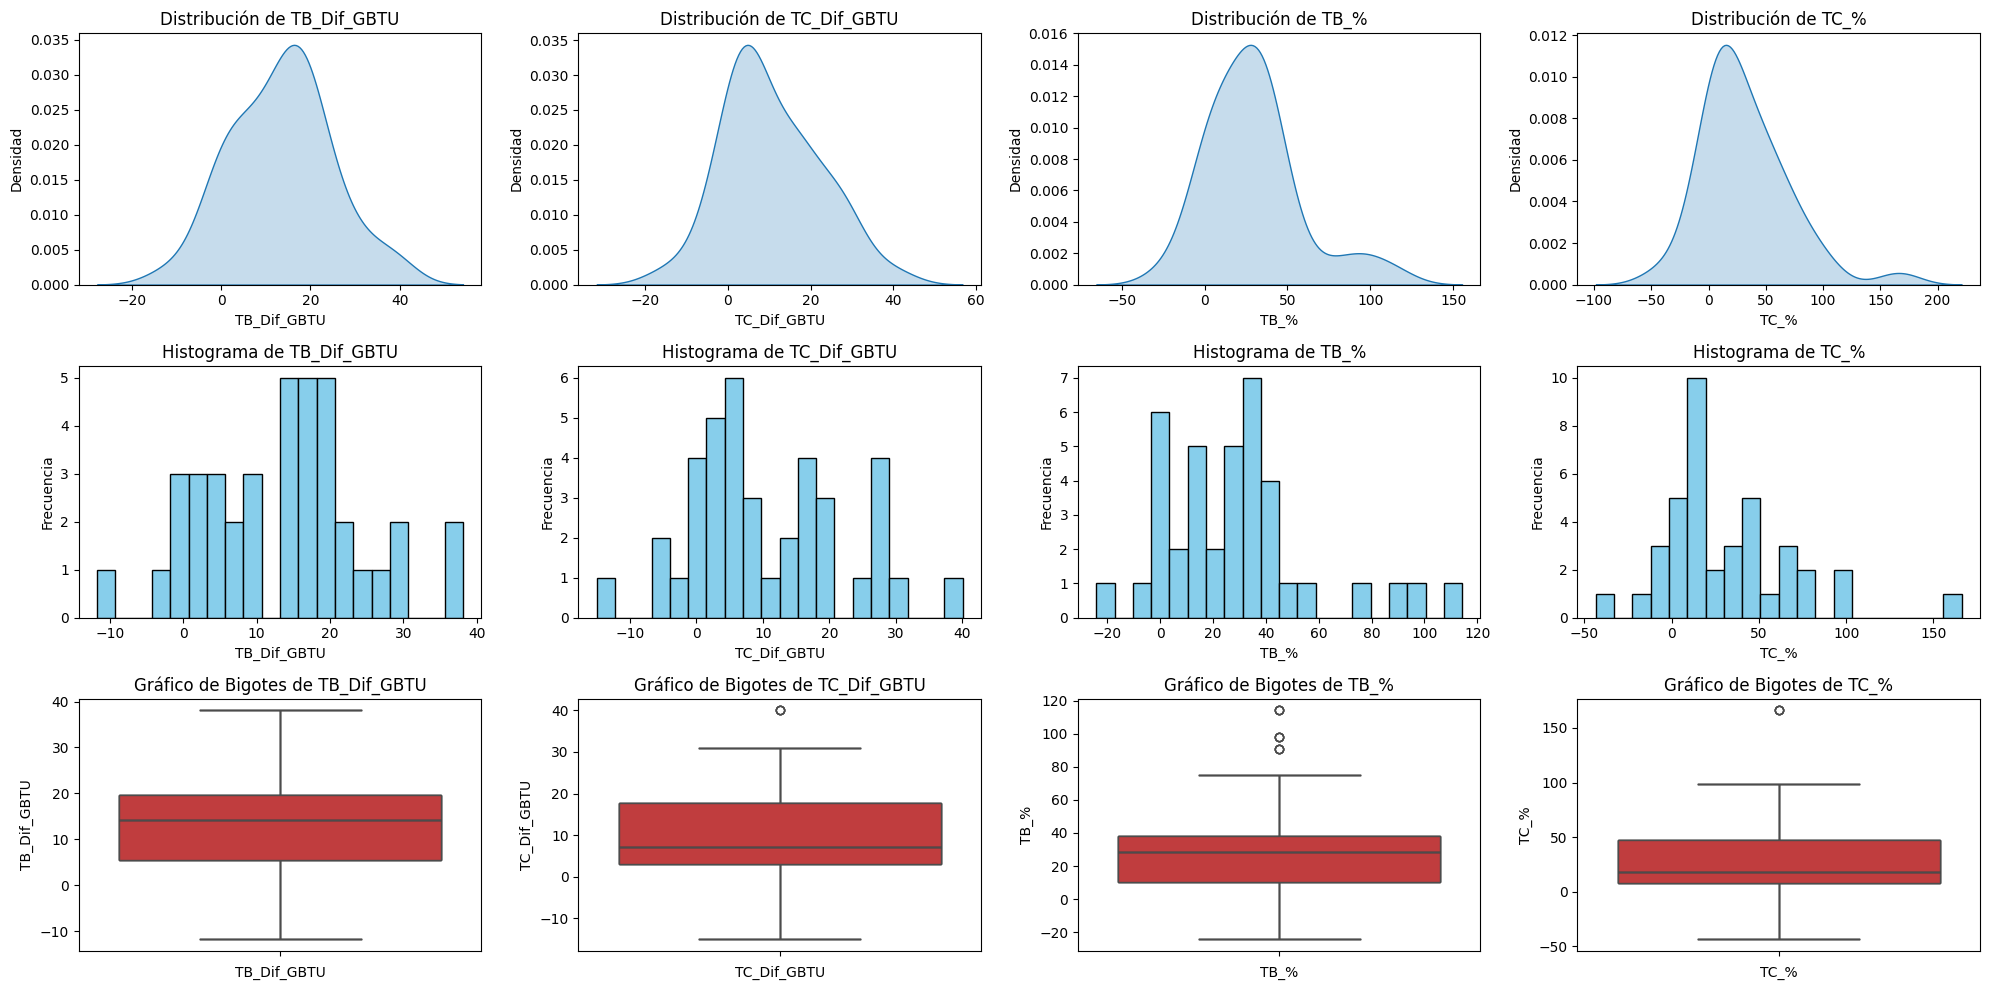

In [13]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Configuración de la figura
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Columnas a graficar
columns = ['TB_Dif_GBTU', 'TC_Dif_GBTU', 'TB_%', 'TC_%']

# Graficar distribuciones de probabilidad
for i, col in enumerate(columns):
    sns.kdeplot(df_proy[col], ax=axes[0, i], fill=True)
    axes[0, i].set_title(f'Distribución de {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Densidad')

# Graficar histogramas de frecuencias
for i, col in enumerate(columns):
    axes[1, i].hist(df_proy[col], bins=20, color='skyblue', edgecolor='black')
    axes[1, i].set_title(f'Histograma de {col}')
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel('Frecuencia')

    # Graficar gráficos de bigotes
    means = {}
    stds={}
    fit_results = {}
    for i, col in enumerate(columns):
        sns.boxplot(data=df_proy, y=col, ax=axes[2, i])
        axes[2, i].set_title(f'Gráfico de Bigotes de {col}')
        axes[2, i].set_xlabel(col)
        axes[2, i].set_ylabel(col)
        means[col] = df_proy[col].mean()
        stds[col] = df_proy[col].std()


        # Validar el ajuste a distribuciones comunes
        distributions = ['norm', 'expon', 'uniform', 'gamma', 'beta']
        

        fit_results[col] = {}
        for dist_name in distributions:
            dist = getattr(stats, dist_name)
            params = dist.fit(df_proy[col])
            ks_stat, p_value = stats.kstest(df_proy[col], dist_name, args=params)
            fit_results[col][dist_name] = {'ks_stat': ks_stat, 'p_value': p_value}



# Mostrar las medias calculadas
print("Medias de las series de datos:")
for col, mean in means.items():
    print(f"{col}: {mean}")

print("Desviaciones standar de las series de datos:")
for col, std in stds.items():
    print(f"{col}: {std}")

# Mostrar los resultados de ajuste
for col, results in fit_results.items():
    print(f"Resultados de ajuste para {col}:")
    for dist_name, metrics in results.items():
        print(f"  {dist_name}: KS-Stat={metrics['ks_stat']:.4f}, p-value={metrics['p_value']:.4f}")

# Ajustar el diseño
plt.tight_layout()
plt.show()